In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

orders = pd.read_csv("data/olist_orders_dataset.csv")
reviews = pd.read_csv("data/olist_order_reviews_dataset.csv")

orders.shape, reviews.shape

((99441, 8), (99224, 7))

In [9]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [10]:
date_cols = [
    "order_purchase_timestamp",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
]

for col in date_cols:
    orders[col] = pd.to_datetime(orders[col], errors="coerce")

orders[date_cols].dtypes


order_purchase_timestamp         datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [11]:
# Unir orders con reviews
df = orders.merge(
    reviews[["order_id", "review_score"]],
    on="order_id",
    how="left",
)

df.shape


(99992, 9)

In [12]:
# Filtrar pedidos validos
df = df[
    df["order_delivered_customer_date"].notna() &
    df["order_estimated_delivery_date"].notna()
].copy()

df.shape

(97005, 9)

In [13]:
# Calcular dias de retraso

df["delay_days"] = (
    df["order_delivered_customer_date"] -
    df["order_estimated_delivery_date"]
).dt.days

df[["delay_days"]].describe()

,delay_days
count,97005.000000
mean,-11.880790
std,10.183992
min,-147.000000
25%,-17.000000
50%,-12.000000
75%,-7.000000
max,188.000000


In [14]:
# Crear bandera "entrega tardía"

df["is_late"] = df["delay_days"] > 0

df["is_late"].value_counts(normalize=True)


is_late
False    0.932344
True     0.067656
Name: proportion, dtype: float64

In [15]:
# ¿LOS RETRASOS AFECTAN EL REVIEW SCORE? Comparacion review score (on time vs delayed)

score_on_time = df.loc[~df["is_late"], "review_score"].mean()
score_late = df.loc[df["is_late"], "review_score"].mean()

score_on_time, score_late

(np.float64(4.289842021590012), np.float64(2.271138845553822))

In [16]:
summary = df.groupby("is_late").agg(
    orders=("order_id", "count"),
    avg_review=("review_score", "mean"),
    avg_delay_days=("delay_days", "mean"),
).reset_index()

summary


,is_late,orders,avg_review,avg_delay_days
0,False,90442,4.289842,-13.514153
1,True,6563,2.271139,10.627914


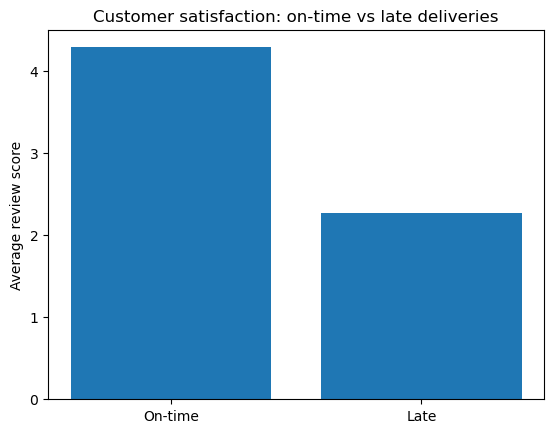

In [17]:
plt.figure()
plt.bar(["On-time", "Late"], [score_on_time, score_late])
plt.ylabel("Average review score")
plt.title("Customer satisfaction: on-time vs late deliveries")
plt.show()


In [18]:
# PRUEBA ESTADÍSTICA
from scipy import stats
on_time_scores = df.loc[~df["is_late"], "review_score"].dropna()
late_scores = df.loc[df["is_late"], "review_score"].dropna()

In [19]:
# Prueba de hipótesis (Mann–Whitney)

stat, p_value = stats.mannwhitneyu(
    on_time_scores,
    late_scores,
    alternative="two-sided"
)

stat, p_value


(np.float64(472134876.0), np.float64(0.0))

## Conclusions

- Only **6.76%** of orders were delivered late, indicating generally strong delivery performance.
- However, delayed deliveries show a **significant drop in customer satisfaction**:
  - On-time deliveries: **~4.29** average review score
  - Late deliveries: **~2.27** average review score
- The difference is **statistically significant** (Mann–Whitney U test, p < 0.05).

Even a small percentage of delivery delays can have a disproportionate negative impact on customer experience.
Improving last-mile performance can therefore generate meaningful gains in customer satisfaction.
